# T20 Cricket Final Score Prediction using Neural Networks
This notebook focuses on making a Machine Learning Model that is able to make Final Score Predictions in T20 format.

## Packages
The first step is to import the relevant packages.

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Activation Functions
The next step is to define the activation functions that we will be using in the neural network

In [30]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z)) 
        
def relu(Z):
    return np.maximum(0, Z)

def tanh(Z):
    return np.tanh(Z)
    
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis = 0, keepdims = True)
    

## Neural Network
Now we have to make the neural network. Here, I have chosen an OOP based approach, so that I can keep my models separate, so that the parameters of one model don't interfere with the parameters of another model. It also makes it easier to manage them.

In [110]:
class Neural_network():
    '''
    Class for a neural network.
    '''
    
    def __init__(self, layer_sizes, layer_activations, learning_rate, epochs, dropout = 1, beta1 = 0.9, beta2 = 0.999, 
                 epsilon = 1e-8):
        '''
        initialize the neural network.
        '''
        self.layer_sizes = layer_sizes
        self.layer_activations = layer_activations
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.epochs = epochs
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.train_costs = []
        self.dev_costs = []
        
        # Initialize parameters of each layer
        self.params = {}
        for i in range(1, len(layer_sizes)):
            self.params['W' + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i - 1]) * 0.01
            self.params['b' + str(i)] = np.zeros((layer_sizes[i], 1))
            
        # Initialize velocity and stuff for Adam
        self.v = {}
        self.s = {}
        
        for i in range(1, len(layer_sizes)):

            self.v["dW" + str(i)] = np.zeros(self.params["W" + str(i)].shape)
            self.v["db" + str(i)] = np.zeros(self.params["b" + str(i)].shape)
            self.s["dW" + str(i)] = np.zeros(self.params["W" + str(i)].shape)
            self.s["db" + str(i)] = np.zeros(self.params["b" + str(i)].shape)
            
            
    def forward_prop(self, X, dropout = False):
        '''
        Performs forward propagation for an iteration.
        '''
        
        A_prev = X
        Z = [0]
        A = [A_prev]
        self.D = []
        
        for i in range(1, len(self.layer_sizes)):
            
            Zi = np.dot(self.params['W' + str(i)], A_prev) + self.params['b' + str(i)]
            if self.layer_activations[i - 1] == 'sigmoid':
                A_prev = sigmoid(Zi)
            elif self.layer_activations[i - 1] == 'relu':
                A_prev = relu(Zi)
            elif self.layer_activations[i - 1] == 'tanh':
                A_prev = tanh(Zi)
            elif self.layer_activations[i - 1] == 'linear':
                A_prev = Zi
            elif self.layer_activations[i - 1] == 'softmax':
                A_prev = softmax(Zi)

            # Don't apply dropout on output layer
            if i != len(self.layer_sizes) - 1 and dropout:
            # Apply dropout 
                Di = np.random.rand(A_prev.shape[0], A_prev.shape[1])
                Di = (Di < self.dropout).astype(int)
                A_prev = A_prev * Di
                A_prev = A_prev / self.dropout
                self.D.append(Di)
            
            A.append(A_prev)
            Z.append(Zi)

        return A, Z
    
    
    def compute_cost(self, Y, Y_hat):
        '''
        Computes the cost of an iteration
        '''
        
        m = Y.shape[1]
        
        if self.layer_activations[-1] == 'sigmoid':
            cost = - np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m 
        elif self.layer_activations[-1] == 'linear':
            cost = np.sum((Y_hat - Y) ** 2) / (2 * m)
        elif self.layer_activations[-1] == 'softmax':
            cost = - np.sum(Y * np.log(Y_hat)) / m
        
        return np.squeeze(cost)
    
    
    def back_prop(self, X, Y, A, Z):
        m = X.shape[1]
        grads = {}
        L = len(self.layer_sizes) - 1
        
        if self.layer_activations[-1] == 'sigmoid':
            dAL = - (np.divide(Y, A[-1]) - np.divide(1 - Y, 1 - A[-1]))
            dZL = A[-1] * (1 - A[-1]) * dAL
        elif self.layer_activations[-1] == 'linear':
            dAL = A[-1] - Y
            dZL = dAL
        elif self.layer_activations[-1] == 'softmax':
            dAL = - Y / A[-1]
            
        A_prev = A[-2]
        
        grads['dW' + str(L)] = np.dot(dZL, A_prev.T) / m
        grads['db' + str(L)] = np.sum(dZL, axis = 1, keepdims = True) / m
        dA_prev = np.dot(self.params['W' + str(L)].T, dZL)
        
        for i in reversed(range(L - 1)):

            dA_prev = dA_prev * self.D[i]
            dA_prev = dA_prev / self.dropout
            Zi = Z[i + 1]
            if self.layer_activations[i] == 'sigmoid':
                dZl = A_prev * (1 - A_prev) * dA_prev
            elif self.layer_activations[i] == 'relu': 
                dZl = np.array(dA_prev, copy=True)
                dZl[Zi <= 0] = 0
            elif self.layer_activations[i] == 'tanh':
                dZl = (1 - A_prev) * dA_prev

            A_prev = A[i]
            
            grads['dW' + str(i + 1)] = np.dot(dZl, A_prev.T) / m
            grads['db' + str(i + 1)] = np.sum(dZl, axis=1, keepdims=True) / m
            dA_prev = np.dot(self.params['W' + str(i + 1)].T, dZl)
            
        return grads
    

    def fit(self, X_train, Y_train, X_dev, Y_dev):
        train_cost = 0
        dev_cost = 0
        for epoch in range(self.epochs):
            A, Z = self.forward_prop(X_train, True)
            train_cost = self.compute_cost(Y_train, A[-1])
            grads = self.back_prop(X_train, Y_train, A, Z)
            self.update_params(grads, epoch + 1)
            self.train_costs.append(train_cost)

            Ad, _ = self.forward_prop(X_dev)
            dev_cost = self.compute_cost(Y_dev, Ad[-1])
            self.dev_costs.append(dev_cost)
            
            if epoch % 100 == 0:
                print(f"Cost at epoch {epoch} is: Train: {train_cost}, Dev: {dev_cost}")
        print(f"Final cost is: Train: {train_cost}, Dev: {dev_cost}")        
        plt.plot(self.train_costs, label = "Train")
        plt.plot(self.dev_costs, label = "Dev")
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.legend()

        A, Z = self.forward_prop(X_train)
        Ad, _ = self.forward_prop(X_dev)
        train_acc = np.sum((np.abs(Y_train - A[-1]) < 20)) / Y_train.shape[1]
        dev_acc = np.sum((np.abs(Y_dev - Ad[-1]) < 20)) / Y_dev.shape[1]
        print(f"The accuracy on train set is : {train_acc * 100:.2f} %")
        print(f"The accuracy on dev set is : {dev_acc * 100: .2f} %")
        
    
    def update_params(self, grads, t):
        # Correction for moving averages
        self.v_corrected = {}            
        self.s_corrected = {} 
        for i in range(1, len(self.layer_sizes)):
            self.v["dW" + str(i)] = self.beta1 * self.v["dW" + str(i)] + (1 - self.beta1) * grads["dW" + str(i)]
            self.v["db" + str(i)] = self.beta1 * self.v["db" + str(i)] + (1 - self.beta1) * grads["db" + str(i)]   
            
            # Bias correction
            self.v_corrected["dW" + str(i)] = self.v["dW" + str(i)] / (1 - self.beta1 ** t)
            self.v_corrected["db" + str(i)] = self.v["db" + str(i)] / (1 - self.beta1 ** t)
            
            # Almost same stuff as v, just with square
            self.s["dW" + str(i)] = self.beta2 * self.s["dW" + str(i)] + (1 - self.beta2) * (grads["dW" + str(i)] ** 2)
            self.s["db" + str(i)] = self.beta2 * self.s["db" + str(i)] + (1 - self.beta2) * (grads["db" + str(i)] ** 2) 
            
            self.s_corrected["dW" + str(i)] = self.s["dW" + str(i)] / (1 - self.beta2 ** t)
            self.s_corrected["db" + str(i)] = self.s["db" + str(i)] / (1 - self.beta2 ** t)
            
            self.params['W' + str(i)] -= self.learning_rate * (self.v_corrected['dW' + str(i)] / np.sqrt(self.s_corrected['dW' + str(i)] + self.epsilon))
            self.params['b' + str(i)] -= self.learning_rate * (self.v_corrected['db' + str(i)] / np.sqrt(self.s_corrected['db' + str(i)] + self.epsilon))
            
            
    def test(self, X, Y):
        A, _ = self.forward_prop(X)
        cost = self.compute_cost(Y, A[-1])
        print(f"The cost on test set is {cost}")
        test_acc = np.sum((np.abs(Y - A[-1]) < 20)) / Y.shape[1]
        print(f"The accuracy on test set is : {test_acc * 100:.2f} %")
        
        return
        
        
    def predict(self, X):
        A, _ = self.forward_prop(X)
        return A[-1]
       

## Testing the Model
The following cell shows that my model works perfectly, and it is able to reduce costs.

Cost at epoch 0 is: Train: 19.916075467749998, Dev: 19.85372705120835
Cost at epoch 1000 is: Train: 0.0014719275201193018, Dev: 0.0014565801878199964
Cost at epoch 2000 is: Train: 1.6609036200187882e-10, Dev: 1.6244499411329144e-10
Cost at epoch 3000 is: Train: 4.000057157182799e-24, Dev: 3.831741695326365e-24
Cost at epoch 4000 is: Train: 1.2466960530886566e-29, Dev: 1.2466960530886566e-29
Cost at epoch 5000 is: Train: 3.702715873881124e-30, Dev: 3.702715873881124e-30
Cost at epoch 6000 is: Train: 8.707052241376918e-31, Dev: 8.707052241376918e-31
Cost at epoch 7000 is: Train: 4.328874217400302e-31, Dev: 4.328874217400302e-31
Cost at epoch 8000 is: Train: 2.987810678524582e-31, Dev: 2.987810678524582e-31
Cost at epoch 9000 is: Train: 2.1595067280425198e-31, Dev: 2.1595067280425198e-31
Final cost is: Train: 2.6821270777514403e-31, Dev: 2.6821270777514403e-31
The accuracy on train set is : 100.00 %
The accuracy on dev set is :  100.00 %


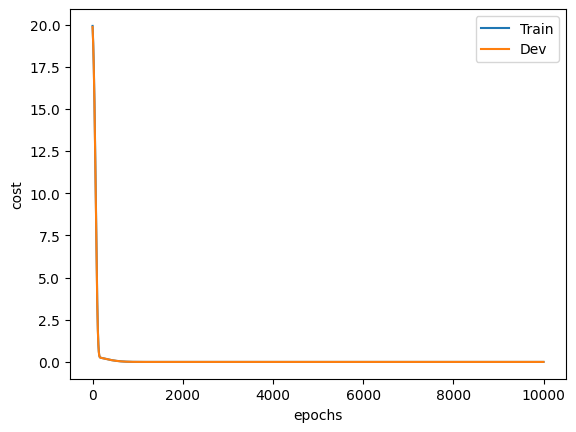

In [32]:
# Generate synthetic data
X_train = np.random.rand(1, 100)
Y_train = 6 * X_train + 3

# Create and train the neural network
model = Neural_network(layer_sizes=[1, 3, 1], layer_activations=['relu', 'linear'], learning_rate=0.01, epochs=10000)
costs = model.fit(X_train, Y_train, X_train, Y_train)

# Test the model
X_test = np.array([[0.5]])
predicted_y = model.predict(X_test)
print(predicted_y)

## Load the Data

In [152]:
# Read the match data csv
match_data = pd.read_csv(r"../Resources/final_score_data.csv")
match_data.head()

,total balls,score,Total Wickets,final score,Afghanistan,Argentina,Australia,Austria,Bahamas,Bahrain,...,Switzerland,Tanzania,Thailand,Turkey,Uganda,United Arab Emirates,United States of America,Vanuatu,West Indies,Zimbabwe
0,0,0,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,0,121,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
country_list = ['Afghanistan', 'Argentina', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belgium', 'Belize', 'Bermuda', 'Bhutan', 'Botswana', 'Bulgaria', 'Cameroon', 'Canada', 'Cayman Islands', 'Cook Islands', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'England', 'Estonia', 'Eswatini', 'Fiji', 'Finland', 'France', 'Gambia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Guernsey', 'Hong Kong', 'Hungary', 'ICC World XI', 'India', 'Indonesia', 'Iran', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Japan', 'Jersey', 'Kenya', 'Kuwait', 'Lesotho', 'Luxembourg', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea', 'Philippines', 'Portugal', 'Qatar', 'Romania', 'Rwanda', 'Samoa', 'Saudi Arabia', 'Scotland', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'St Helena', 'Swaziland', 'Sweden', 'Switzerland', 'Tanzania', 'Thailand', 'Turkey', 'Uganda', 'United Arab Emirates', 'United States of America', 'Vanuatu', 'West Indies', 'Zimbabwe']

print(len(country_list))
def one_hot(target_country):
    '''
    This function takes a country, and returns a one hot encoded np array
    '''
    one_hot_encoded = [int(country == target_country) for country in country_list]
    return np.array(one_hot_encoded)


95


# Training the model
Now I convert the relevant data into numpy arrays, divide it into train, dev and test sets in a ratio of 96/2/2 (since I have a lot of data), and feed them into a model. My first model is a simple linear regression model so that I can set the baseline for accuracy.

In [154]:
# Specify the X and Y labels
Y = match_data[["final score"]].to_numpy()
match_data = match_data.drop(columns=["final score"])
X = match_data.to_numpy()
scaler = sklearn.preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)
X = X.T
Y = Y.T
print(X.shape)
print(Y.shape)

(98, 407789)
(1, 407789)


In [155]:
# Split into train/dev and test sets
train_ratio = 0.96
dev_ratio = 0.02
# Test and dev ratio are same

total_examples = X.shape[1]
train_size = int(train_ratio * total_examples)
dev_size = int(dev_ratio * total_examples)


# Shuffle the arrays
indices = np.random.permutation(total_examples)
X, Y = X[:,indices], Y[:,indices]
#X, Y = X[indices], Y[indices]

# Finally, split the data
X_train, X_dev, X_test = X[:,:train_size], X[:,train_size:train_size + dev_size], X[:, train_size + dev_size:]
Y_train, Y_dev, Y_test = Y[:,:train_size], Y[:,train_size:train_size + dev_size], Y[:, train_size + dev_size:]
#X_train, X_dev, X_test = X[:train_size], X[train_size:train_size + dev_size], X[train_size + dev_size:]
#Y_train, Y_dev, Y_test = Y[:train_size], Y[train_size:train_size + dev_size], Y[train_size + dev_size:]



Cost at epoch 0 is: Train: 11327.306827903501, Dev: 6436.541994951683
Cost at epoch 100 is: Train: 1647.4809683955255, Dev: 1614.749147022662
Final cost is: Train: 840.1074563296136, Dev: 819.8367362718022
The accuracy on train set is : 40.54 %
The accuracy on dev set is :  41.08 %
The cost on test set is 826.7796253612383
The accuracy on test set is : 40.60 %


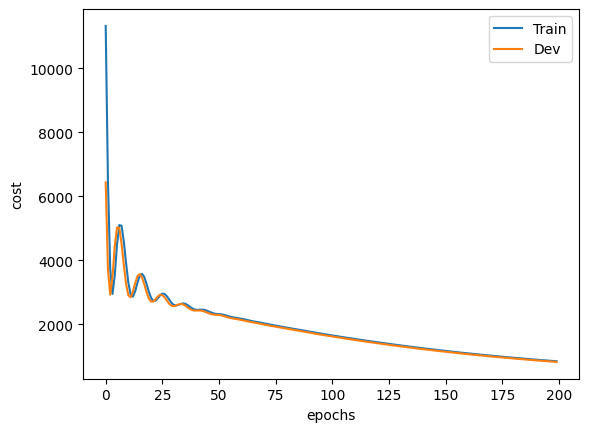

In [84]:
# Now create and train the model
final_score_predictor = Neural_network(layer_sizes=[98, 1], layer_activations=['linear'], 
                                      learning_rate = 0.3, epochs = 200)

final_score_predictor.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor.test(X_test, Y_test)

Cost at epoch 0 is: Train: 351.739677564767, Dev: 353.819978693361
Cost at epoch 100 is: Train: 351.739317471744, Dev: 353.82114811508325
Cost at epoch 200 is: Train: 351.7387218389813, Dev: 353.8231414951013
Final cost is: Train: 351.7379844903665, Dev: 353.8257023988222
The accuracy on train set is : 63.79 %
The accuracy on dev set is :  63.08 %
The cost on test set is 350.8747923460027
The accuracy on test set is : 64.34 %


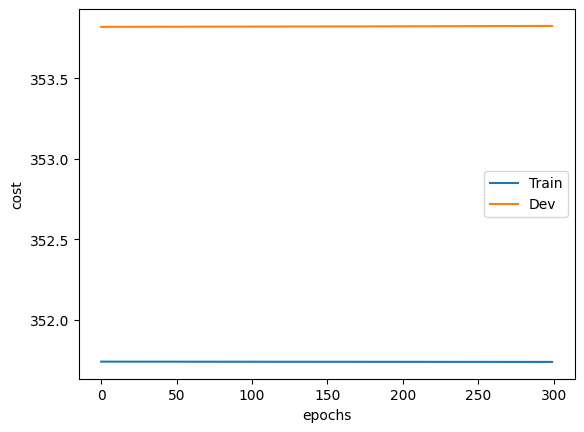

In [90]:
# Train the model more to make fine adjustments
final_score_predictor.learning_rate = 0.01
final_score_predictor.epochs = 300
final_score_predictor.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor.test(X_test, Y_test)

### Result
So I got an accuracy of about 64% on the linear model, Let's try a slightly more complex model

Cost at epoch 0 is: Train: 11067.782512127149, Dev: 11085.122920547286
Cost at epoch 100 is: Train: 11017.845846302484, Dev: 11031.157870674508
Final cost is: Train: 803.6098995010076, Dev: 808.5176583168471
The accuracy on train set is : 38.27 %
The accuracy on dev set is :  37.67 %
The cost on test set is 805.4157240494841
The accuracy on test set is : 37.97 %


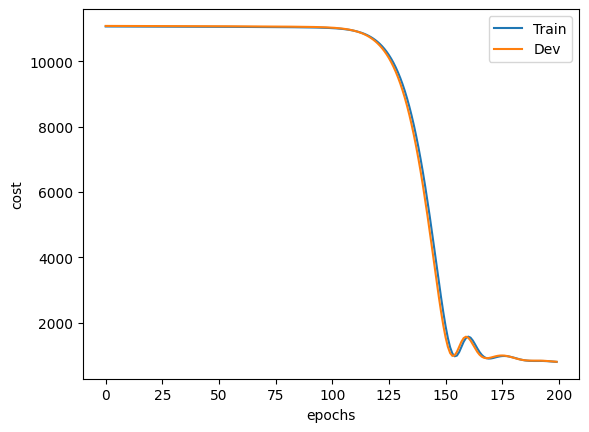

In [168]:
# Training model no 2
final_score_predictor2 = Neural_network(layer_sizes=[98,75,50,25,12,6,5,4,1], layer_activations=['relu','relu','relu','relu','relu','relu','relu','linear'], 
                                      learning_rate = 0.001, epochs = 200, dropout = 1)

final_score_predictor2.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor2.test(X_test, Y_test)

In [ ]:
# Train the model more to make fine adjustments
final_score_predictor2.learning_rate = 0.001
final_score_predictor2.epochs = 100
final_score_predictor2.fit(X_train, Y_train, X_dev, Y_dev)
final_score_predictor2.test(X_test, Y_test)

Cost at epoch 0 is: Train: 798.0499463476168, Dev: 804.9976461275214


In [121]:
r2_score(Y_test.T, final_score_predictor2.predict(X_test).T)

0.5043060296920086

In [151]:
predicted_score = round(float(final_score_predictor2.predict(scaler.transform(np.concatenate([[114,80,5],one_hot("Pakistan")])).reshape(-1, 1))))
print(f"The model predicts a final score of {predicted_score}")

ValueError: X has 1 features, but MinMaxScaler is expecting 407789 features as input.